## Imports

In [35]:
import sys
sys.path.append('/Users/mariacarvalho/Documents/GitHub/Bioinformatics-Project/propythia')
from src.propythia.protein.descriptors import ProteinDescritors

In [ ]:
sys.path.append('/Users/mariacarvalho/Documents/GitHub/Bioinformatics-Project/propythia/src/propythia')
from ml.shallow_ml import ShallowML

In [ ]:
import requests
import re
import pandas as pd
import requests
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from io import StringIO
from urllib.parse import quote_plus
from Bio import SeqIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.feature_selection import f_classif, mutual_info_classif, chi2

##  Retrieve Anti-Restriction Proteins from UniProt (E. coli)

In [ ]:
# 1) Define list of anti-restriction 
anti_re = [
    "ArdA",
    "ArdB",
    "Stp",
    "Ocr",
    "Arn",
    "Internal protein I",
    "Mom",
    "DNA Beta-Glucosyltransferase",
    "S-adenosyl-methionine lyase"
]

# 2) Build the gene portion of the query using OR
gene_query = " OR ".join(f'gene:"{g}"' for g in anti_re)

# 3) Full query for all E. coli strains (NCBI taxon 562)
query = f'organism_id:562 AND ({gene_query})'

# 4) URL-encode the query
encoded_query = quote_plus(query)

# 5) Construct UniProt REST URLs for FASTA and TSV
fasta_url = (
    "https://rest.uniprot.org/uniprotkb/stream"
    f"?query={encoded_query}&format=fasta"
)
tsv_url = (
    "https://rest.uniprot.org/uniprotkb/search"
    f"?query={encoded_query}&format=tsv"
    "&fields=accession,id,protein_name,organism_name,sequence"
)

# 6) Fetch FASTA data
response_fasta = requests.get(fasta_url)
response_fasta.raise_for_status()
fasta_data = response_fasta.text

# 7) Parse FASTA records and report
records = list(SeqIO.parse(StringIO(fasta_data), "fasta"))
print(f"Retrieved {len(records)} sequences:\n")
for rec in records:
    print(f" • {rec.id}: {rec.description}")

# 8) Save FASTA to file
with open("antirestriction_ecoli.fasta", "w") as fh:
    fh.write(fasta_data)

# 9) Fetch metadata as TSV and load into DataFrame
response_tsv = requests.get(tsv_url)
response_tsv.raise_for_status()
df = pd.read_csv(StringIO(response_tsv.text), sep="\t")

# 10) Preview and save metadata
print("\nMetadata preview:")
print(df.head().to_string(index=False))
df.to_csv("antirestriction_ecoli_metadata.csv", index=False)

Retrieved 34 sequences:

 • tr|Q6SJ51|Q6SJ51_ECOLX: tr|Q6SJ51|Q6SJ51_ECOLX Anti-restriction protein OS=Escherichia coli OX=562 GN=yciB PE=3 SV=1
 • tr|A0A023PZR5|A0A023PZR5_ECOLX: tr|A0A023PZR5|A0A023PZR5_ECOLX ArdB OS=Escherichia coli OX=562 GN=ardB PE=3 SV=1
 • tr|A0A069FPX5|A0A069FPX5_ECOLX: tr|A0A069FPX5|A0A069FPX5_ECOLX Antirestriction protein OS=Escherichia coli OX=562 GN=ardB PE=3 SV=1
 • tr|A0A069FQU3|A0A069FQU3_ECOLX: tr|A0A069FQU3|A0A069FQU3_ECOLX ArdA OS=Escherichia coli OX=562 GN=ardA PE=4 SV=1
 • tr|A0A075ME94|A0A075ME94_ECOLX: tr|A0A075ME94|A0A075ME94_ECOLX Antirestriction protein ArdA OS=Escherichia coli OX=562 GN=ardA PE=4 SV=1
 • tr|A0A075UHJ0|A0A075UHJ0_ECOLX: tr|A0A075UHJ0|A0A075UHJ0_ECOLX Antirestriction protein OS=Escherichia coli OX=562 GN=ardB PE=3 SV=1
 • tr|A0A075UIQ7|A0A075UIQ7_ECOLX: tr|A0A075UIQ7|A0A075UIQ7_ECOLX Antirestriction protein OS=Escherichia coli OX=562 GN=ardA PE=4 SV=1
 • tr|A0A097SRD5|A0A097SRD5_ECOLX: tr|A0A097SRD5|A0A097SRD5_ECOLX Antirestrict

### Filter FASTA Sequences to Remove Uncharacterized Entries

In [37]:
# Load file
input_file = "antirestriction_ecoli.fasta"
output_file = "filtered_anti_ecoli.fasta"

# Keywords to exclude
exclude_keywords = ["hypothetical", "putative", "uncharacterized"]

def is_characterized(record):
    description = record.description.lower()
    return not any(keyword in description for keyword in exclude_keywords)

# Load and filter sequences
records = list(SeqIO.parse(input_file, "fasta"))
filtered_records = [rec for rec in records if is_characterized(rec)]

# Save filtered sequences
SeqIO.write(filtered_records, output_file, "fasta")

print(f"Saved {len(filtered_records)} filtered sequences to: {output_file}")

Saved 33 filtered sequences to: filtered_anti_ecoli.fasta


## Retrieve Anti-Restriction Genes from UniProt (All Bacteria)

In [ ]:
# 1) Define list of anti-restriction
anti_re = [
    "ArdA",
    "ArdB",
    "Stp",
    "Ocr",
    "Arn",
    "Internal protein I",
    "Mom",
    "DNA Beta-Glucosyltransferase",
    "S-adenosyl-methionine lyase"
]

# 2) Build the gene portion of the query using OR
gene_query = " OR ".join(f'gene:"{g}"' for g in anti_re)

# 3) Full query for **all** bacteria (NCBI taxon 2)
query = f'taxonomy_id:2 AND ({gene_query})'

# 4) URL-encode the query
encoded_query = quote_plus(query)

# 5) Construct UniProt REST URLs for FASTA and TSV
fasta_url = (
    "https://rest.uniprot.org/uniprotkb/stream"
    f"?query={encoded_query}&format=fasta"
)
tsv_url = (
    "https://rest.uniprot.org/uniprotkb/search"
    f"?query={encoded_query}&format=tsv"
    "&fields=accession,id,protein_name,organism_name,sequence"
)

# 6) Fetch FASTA data
response_fasta = requests.get(fasta_url)
response_fasta.raise_for_status()
fasta_data = response_fasta.text

# 7) Parse FASTA records and report
records = list(SeqIO.parse(StringIO(fasta_data), "fasta"))
print(f"Retrieved {len(records)} sequences:\n")
for rec in records:
    print(f" • {rec.id}: {rec.description}")

# 8) Save FASTA to file
with open("antirestriction_bacteria.fasta", "w") as fh:
    fh.write(fasta_data)

# 9) Fetch metadata as TSV and load into DataFrame
response_tsv = requests.get(tsv_url)
response_tsv.raise_for_status()
df = pd.read_csv(StringIO(response_tsv.text), sep="\t")

# 10) Preview and save metadata
print("\nMetadata preview:")
print(df.head().to_string(index=False))
df.to_csv("antirestriction_bacteria_metadata.csv", index=False)


Retrieved 6414 sequences:

 • sp|Q8Y678|STP1_LISMO: sp|Q8Y678|STP1_LISMO Serine/threonine phosphatase stp OS=Listeria monocytogenes serovar 1/2a (strain ATCC BAA-679 / EGD-e) OX=169963 GN=stp PE=1 SV=1
 • sp|B1KN79|ARDA_SHEWM: sp|B1KN79|ARDA_SHEWM Acrylate reductase flavoprotein subunit OS=Shewanella woodyi (strain ATCC 51908 / MS32) OX=392500 GN=ardA PE=1 SV=1
 • sp|B1KN80|ARDB_SHEWM: sp|B1KN80|ARDB_SHEWM Acrylate reductase cytochrome subunit OS=Shewanella woodyi (strain ATCC 51908 / MS32) OX=392500 GN=ardB PE=1 SV=1
 • tr|D2TVW4|D2TVW4_9GAMM: tr|D2TVW4|D2TVW4_9GAMM Bifunctional polymyxin resistance protein ArnA OS=Arsenophonus nasoniae OX=638 GN=arnA PE=3 SV=1
 • tr|D2TW52|D2TW52_9GAMM: tr|D2TW52|D2TW52_9GAMM Bifunctional aspartokinase/homoserine dehydrogenase OS=Arsenophonus nasoniae OX=638 GN=thrA PE=3 SV=1
 • tr|D2TW85|D2TW85_9GAMM: tr|D2TW85|D2TW85_9GAMM Carbamoyl phosphate synthase large chain OS=Arsenophonus nasoniae OX=638 GN=carB PE=3 SV=1
 • tr|D2TWB1|D2TWB1_9GAMM: tr|D2TWB1

### Filter FASTA Sequences to Remove Uncharacterized Entries

In [39]:
from Bio import SeqIO

# Load file
input_file = "antirestriction_bacteria.fasta"
output_file = "filtered_anti_bact.fasta"

# Keywords to exclude
exclude_keywords = ["hypothetical", "putative", "uncharacterized"]

def is_characterized(record):
    description = record.description.lower()
    return not any(keyword in description for keyword in exclude_keywords)

# Load and filter sequences
records = list(SeqIO.parse(input_file, "fasta"))
filtered_records = [rec for rec in records if is_characterized(rec)]

# Save filtered sequences
SeqIO.write(filtered_records, output_file, "fasta")

print(f"Saved {len(filtered_records)} filtered sequences to: {output_file}")

Saved 5820 filtered sequences to: filtered_anti_bact.fasta


## NCBI Virus Search: Identification of Non-Anti-Restriction Caudoviricetes Infecting *E. coli*

This query retrieves viral genomes from the **RefSeq** database, specifically **Caudoviricetes** viruses that infect *Escherichia coli*, while **excluding any entries** associated with known anti-restriction genes.

---

### Search Parameters

- **Taxonomic Group:** `Caudoviricetes`  
  → `txid2731619`

- **Host Organism:** *Escherichia coli*

- **Database Source:** RefSeq only  
  → `srcdb_refseq[Properties]`

---

### Exclusion Criteria (Anti-Restriction Genes)

The following known anti-restriction genes were **excluded** from the search:

- ArdA  
- ArdB  
- Ocr  
- Stp  
- Arn  
- Internal Protein I  
- DNA Adenine Methylase  
- DNA N-6-Adenine-Methyltransferase  
- DNA Beta-Glucosyltransferase  
- Methylcarbamoylase Mom  
- S-adenosyl-methionine lyase  

---

### Complete NCBI Query

```txt
txid2731619[Organism] AND "Escherichia coli"[Host] AND srcdb_refseq[Properties]
NOT ArdA[Text Word]
NOT Ocr[Text Word]
NOT Stp[Text Word]
NOT Arn[Text Word]
NOT "Internal Protein I"[Text Word]
NOT "DNA Adenine Methylase"[Text Word]
NOT "DNA N-6-Adenine-Methyltransferase"[Text Word]
NOT "DNA Beta-Glucosyltransferase"[Text Word]
NOT "Methylcarbamoylase Mom"[Text Word]
NOT "S-adenosyl-methionine lyase"[Text Word]
NOT ArdB[Text Word]


### Filtering the Data

In [40]:
# Load file
input_file = "not_antiRE.fasta"
output_file = "filtered_not_antiRE.fasta"

# Keywords to exclude
exclude_keywords = ["hypothetical", "putative", "uncharacterized"]

def is_characterized(record):
    description = record.description.lower()
    return not any(keyword in description for keyword in exclude_keywords)

# Load and filter sequences
records = list(SeqIO.parse(input_file, "fasta"))
filtered_records = [rec for rec in records if is_characterized(rec)]

# Save filtered sequences
SeqIO.write(filtered_records, output_file, "fasta")

print(f"Saved {len(filtered_records)} filtered sequences to: {output_file}")

Saved 239580 filtered sequences to: filtered_not_antiRE.fasta


## Sequence Labeling for Anti-Restriction Classifier


In [41]:
# Define input FASTA files and their labels
fasta_files = {
    "filtered_anti_bact.fasta": 1,  # positives
    "filtered_not_antiRE.fasta": 0       # negatives
}

# Read and label sequences
records = []
for file_path, label in fasta_files.items():
    for record in SeqIO.parse(file_path, "fasta"):
        records.append({
            "id": record.id,
            "description": record.description,
            "sequence": str(record.seq),
            "label": label
        })

# Create and save DataFrame
df = pd.DataFrame(records)
df.to_csv("labeled_sequences.csv", index=False)
print(" Saved labeled_sequences.csv with shape:", df.shape)


 Saved labeled_sequences.csv with shape: (245400, 4)


In [43]:
df = pd.read_csv("labeled_sequences.csv")

#Split into positives and negatives
positives = df[df["label"] == 1]
negatives = df[df["label"] == 0]

print(f"Positives: {len(positives)} | Negatives: {len(negatives)}")

# Combine all data, keeping full imbalance
df_realistic = pd.concat([positives, negatives], ignore_index=True)

# Shuffle (important for ML)
df_realistic = df_realistic.sample(frac=1, random_state=42).reset_index(drop=True)

# Save
df_realistic.to_csv("ecoli_realistic_imbalanced.csv", index=False)
print(f"Final dataset shape: {df_realistic.shape}")

Positives: 5820 | Negatives: 239580
Final dataset shape: (245400, 4)


## Balancing Labeled Sequence Dataset

This script ensures that negative examples (label `0`) do not exceed twice the number of positive examples (label `1`) before saving the combined dataset.

In [44]:
n_positive = len(positives)
n_negative_to_keep = min(len(negatives), 2 * n_positive)
negative_df_sampled = negatives.sample(n=n_negative_to_keep, random_state=42)

# Combine
balanced_df = pd.concat([positives, negative_df_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)

# Save or inspect
balanced_df.to_csv("balanced_dataset.csv", index=False)
print("Balanced dataset saved with shape:", balanced_df.shape)
print(f"Positives: {n_positive} | Negatives: {n_negative_to_keep}")

Balanced dataset saved with shape: (17460, 4)
Positives: 5820 | Negatives: 11640


In [45]:
valid_aa = re.compile(r'^[ACDEFGHIKLMNPQRSTVWY]+$')
balanced_df = balanced_df[balanced_df['sequence'].apply(lambda seq: bool(valid_aa.fullmatch(seq)))]

print("After filtering valid amino acid sequences:", balanced_df.shape)

After filtering valid amino acid sequences: (17420, 4)


## Generating Protein Sequence Descriptors

This step computes protein descriptors (physicochemical properties) from a balanced dataset of protein sequences.


In [46]:
descriptors_df = ProteinDescritors(dataset= balanced_df ,  col= 'sequence')
descriptors_df.dataset

,id,description,sequence,label
0,YP_009224817.1,YP_009224817.1 thymidylate synthase [Pseudomon...,MAEYNLSLEDLMLVDGFKEAFQSNNEKVVREHLWTNGMDVKNYSYE...,0
1,YP_009821807.1,YP_009821807.1 head-tail adaptor [Shigella pha...,MASSQKREGFAENGAKAVYDSLKNDRNSYETRAENCAKYTIPSLFP...,0
2,YP_004324979.1,YP_004324979.1 peptidase [Prochlorococcus phag...,MNTQEVKGTLAKLLATENLTVEHRRVSTACFDVDKRLLILPIWKTA...,0
3,tr|A0A0P1I153|A0A0P1I153_9RHOB,tr|A0A0P1I153|A0A0P1I153_9RHOB Spectinomycin t...,MSKGWKATFRSKSSCTHSEGLVVWPALFYWHTALTNRIAPDLMGPV...,1
4,YP_009951485.1,YP_009951485.1 head-tail adaptor [Mycobacteriu...,MYPTPFTVLHTTYVKDGENAAGQVTTKPVTFPRKVSSLRPRVNEPG...,0
...,...,...,...,...
17454,YP_009208434.1,YP_009208434.1 minor tail protein [Mycobacteri...,MTYPVTPDPSIHNVPARNRAQDQQQIINQLRTLFLALPKAILSQVV...,0
17455,YP_655036.1,YP_655036.1 endonuclease [Mycobacterium phage ...,MATKKRRTRGDGAFFQRADGKWMGRVELPPDRNGNRRYKWVSSVDR...,0
17457,tr|D2U2U9|D2U2U9_9GAMM,tr|D2U2U9|D2U2U9_9GAMM ProQ/FinO domain-contai...,MWQEVKDKCLPIARRRLRACLGSIGHHADYRGLIQLGAFRYDKDGQ...,1
17458,tr|D2U027|D2U027_9GAMM,tr|D2U027|D2U027_9GAMM Large ribosomal subunit...,MSNIIKQLEQEQMKQNIPSFRPGDTVEVKVWVVEGSKRRLQAFEGV...,1


In [47]:
df = descriptors_df.get_all_physicochemical(ph=7, amide=False, n_jobs=1)

## Preprocessing and Feature Selection for Protein Sequence Classification

This workflow performs feature cleaning, scaling, and selection before training machine learning models on protein sequence descriptors.


### Remove Constant and Duplicate Features

In [48]:
df2 = df.loc[:, (df != 0).any()]

print(df2.shape)

(16866, 29)


In [ ]:
# remove columns that have the same values 
df2 = df2.loc[:, ~df2.T.duplicated(keep='first')]
print(df2.shape)

(16866, 29)


In [50]:
print(df2.columns)

Index(['id', 'description', 'sequence', 'label', 'length', 'charge',
       'chargedensity', 'formulaC', 'formulaH', 'formulaN', 'formulaO',
       'formulaS', 'tot', 'hydrogen', 'single', 'double', 'MW_modlamp',
       'Gravy', 'Aromacity', 'IsoelectricPoint', 'Instability_index',
       'SecStruct_helix', 'SecStruct_turn', 'SecStruct_sheet',
       'Molar_extinction_coefficient_reduced',
       'Molar_extinction_coefficient_oxidized', 'aliphatic_index',
       'bomanindex', 'hydrophobic_ratio'],
      dtype='object')


### Split into Training and Test Sets and  Feature Scaling

In [51]:
X = df2.drop(columns=['id','description','sequence','label'])
y = df2['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
print('train_x', X_train.shape)
print('test_x', X_test.shape)


scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

train_x (11300, 25)
test_x (5566, 25)


In [52]:
print("Columns going into selection:", X.columns.tolist())

Columns going into selection: ['length', 'charge', 'chargedensity', 'formulaC', 'formulaH', 'formulaN', 'formulaO', 'formulaS', 'tot', 'hydrogen', 'single', 'double', 'MW_modlamp', 'Gravy', 'Aromacity', 'IsoelectricPoint', 'Instability_index', 'SecStruct_helix', 'SecStruct_turn', 'SecStruct_sheet', 'Molar_extinction_coefficient_reduced', 'Molar_extinction_coefficient_oxidized', 'aliphatic_index', 'bomanindex', 'hydrophobic_ratio']


###  Feature Selection

In [ ]:
transformer = GenericUnivariateSelect(mutual_info_classif, mode='percentile', param=50).fit(X_train, y_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(11300, 12)
(5566, 12)


## Machine Learning on Protein Descriptors: Feature Selection & Model Evaluation

This pipeline performs **feature selection**, **model training**, and **evaluation** using protein sequence descriptors derived from balanced, labeled FASTA data.

### Feature Selection with Mutual Information

In [54]:
# assess the selected features 

scores = transformer.scores_  # scores of features
p_values = transformer.pvalues_  # p features

# get columns selected
column_selected = transformer.get_support(indices=True)  # indexes of selected columns
column_selected_names = X.columns[column_selected]

f_scores = pd.DataFrame(scores, index=X.columns,columns=['features_rank']).sort_values(by=['features_rank'], ascending=False)

print("Top 20 features (by mutual information):")
print(f_scores.head(20))

print("\nSelected features:")
print(column_selected_names.tolist())

Top 20 features (by mutual information):
                                       features_rank
aliphatic_index                             0.185950
hydrophobic_ratio                           0.178833
Gravy                                       0.164013
bomanindex                                  0.128636
tot                                         0.104793
length                                      0.101149
formulaC                                    0.099358
formulaH                                    0.098873
single                                      0.097865
MW_modlamp                                  0.094678
hydrogen                                    0.094399
formulaN                                    0.093656
double                                      0.092916
formulaO                                    0.090641
SecStruct_sheet                             0.089306
Molar_extinction_coefficient_oxidized       0.078372
SecStruct_helix                             0.070961
SecSt

In [55]:
print(f"X_train shape after selection: {X_train.shape}")
print(f"Number of selected column names: {len(column_selected_names)}")

X_train shape after selection: (11300, 12)
Number of selected column names: 12


### Train Random Forest Classifier

In [ ]:
ml = ShallowML(x_train=X_train, x_test=X_test, y_train=y_train, y_test=y_test,
               report_name=None, columns_names= column_selected_names)

# TRAIN BEST MODEL
best_rf_model = ml.train_best_model(model = 'rf', scaler=None,
                                     score=make_scorer(matthews_corrcoef),
                                     cv=5, optType='gridSearch',
                                     param_grid=None,
                                     n_jobs=40, random_state=1, refit=True)

#SCORES
scores, report, cm, cm2 = ml.score_testset(classifier=best_rf_model)
print(report)
print(cm)
for key, value in scores.items():
    print(f"{key}: {value}")

performing gridSearch...
GridSearchCV took 63.21 seconds for 6 candidate parameter settings.
GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scl', None),
                                       ('clf',
                                        RandomForestClassifier(random_state=1))]),
             n_jobs=40,
             param_grid=[{'clf__bootstrap': [True], 'clf__criterion': ['gini'],
                          'clf__max_features': ['sqrt', 'log2'],
                          'clf__n_estimators': [10, 100, 500]}],
             scoring=make_scorer(matthews_corrcoef, response_method='predict'))
Model with rank: 1
 Mean validation score: 0.701 (std: 0.010)
 Parameters: {'clf__bootstrap': True, 'clf__criterion': 'gini', 'clf__max_features': 'sqrt', 'clf__n_estimators': 100}
 

Model with rank: 1
 Mean validation score: 0.701 (std: 0.010)
 Parameters: {'clf__bootstrap': True, 'clf__criterion': 'gini', 'clf__max_features': 'log2', 'clf__n_estimators': 100}
 

Model with rank: 3
 Me

### Visualize Confusion Matrix – Random Forest

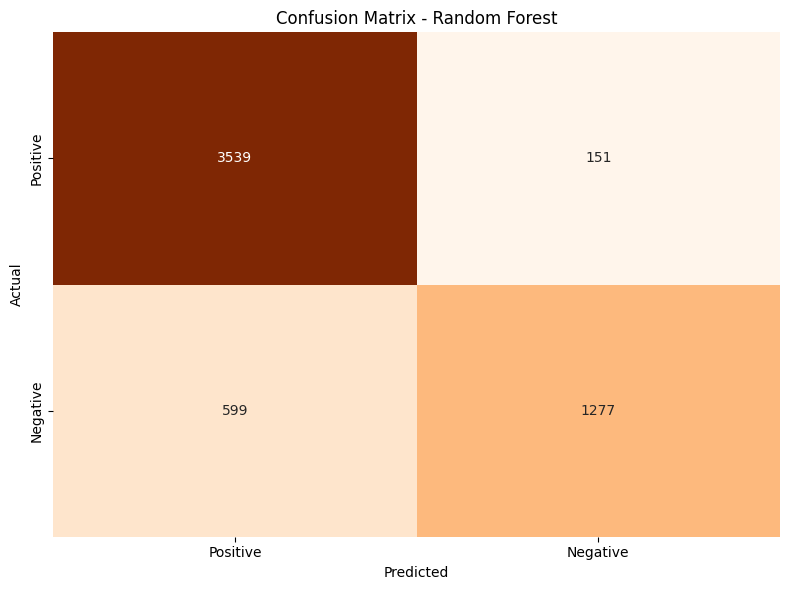

In [79]:
conf_matrix = np.array([[3539, 151],
                        [599, 1277]])



plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', cbar=False,
                 xticklabels=['Positive', 'Negative'],
                 yticklabels=['Positive', 'Negative'])


plt.title(f'Confusion Matrix - Random Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()


### Feature Importance – Random ForestFeature Importance – Random Forest

In [58]:
rf = best_rf_model.named_steps['clf']  # extract the RandomForestClassifier from pipeline
importances = rf.feature_importances_  # extract feature importances

              Feature  Importance
9     aliphatic_index    0.220336
8               Gravy    0.138566
11  hydrophobic_ratio    0.112415
10         bomanindex    0.086710
5            hydrogen    0.062334
1            formulaC    0.060566
4                 tot    0.057255
2            formulaH    0.055568
0              length    0.054654
6              single    0.053330


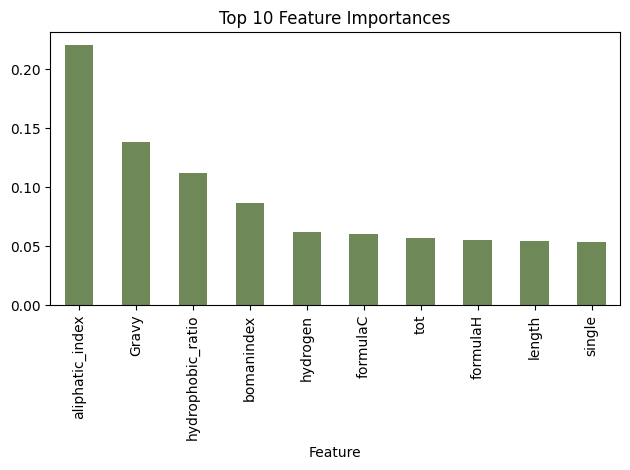

In [ ]:
feature_importance_df = pd.DataFrame({
    'Feature': column_selected_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Top 10 features
print(feature_importance_df.head(10))

# Plot
feature_importance_df.head(10).plot.bar(x='Feature', y='Importance', legend=False, color = '#6e8957')
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()



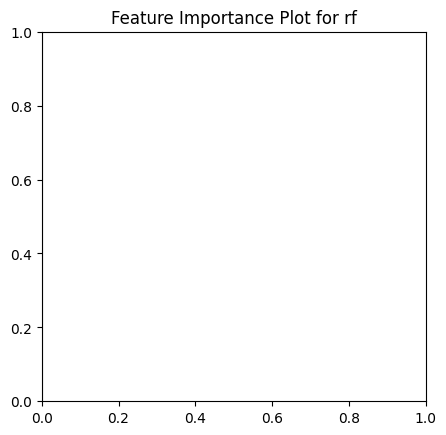

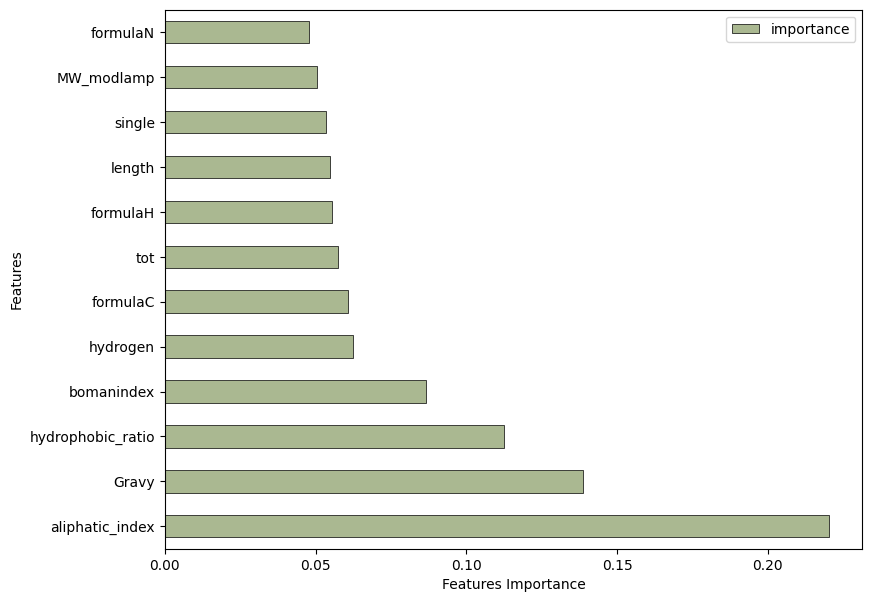

<Figure size 640x480 with 0 Axes>

In [60]:
ml.features_importances_plot(
    classifier=best_rf_model, 
    top_features=30, 
    model_name='rf',
    show=True, 
    path_save=None,
    color='#aab891'
)

## Train and Evaluate SVC (RBF / Linear Kernels)

In [61]:
# SVC
param_grid = {'clf__C': [0.1, 1.0, 10],
                        'clf__kernel': ['rbf', 'linear'],
                        'clf__gamma': [0.001,0.0001]}


ml = ShallowML(x_train=X_train, x_test=X_test, y_train=y_train, y_test=y_test,
               report_name=None, columns_names= column_selected_names)

# TRAIN BEST MODEL

# Score - MCC
best_model = ml.train_best_model(model = 'svc', scaler=None,
                                     score=make_scorer(matthews_corrcoef),
                                     cv=5, optType='gridSearch',
                                     param_grid=param_grid,
                                     n_jobs=2, random_state=1, n_iter=15, refit=True)

scores, report, cm, cm2 = ml.score_testset(classifier=best_model)
print(report)
print(cm)
for key, value in scores.items():
    print(f"{key}: {value}")

performing gridSearch...
GridSearchCV took 111.21 seconds for 12 candidate parameter settings.
GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scl', None),
                                       ('clf', SVC(random_state=1))]),
             n_jobs=2,
             param_grid={'clf__C': [0.1, 1.0, 10],
                         'clf__gamma': [0.001, 0.0001],
                         'clf__kernel': ['rbf', 'linear']},
             scoring=make_scorer(matthews_corrcoef, response_method='predict'))
Model with rank: 1
 Mean validation score: 0.531 (std: 0.020)
 Parameters: {'clf__C': 10, 'clf__gamma': 0.001, 'clf__kernel': 'linear'}
 

Model with rank: 1
 Mean validation score: 0.531 (std: 0.020)
 Parameters: {'clf__C': 10, 'clf__gamma': 0.0001, 'clf__kernel': 'linear'}
 

Model with rank: 3
 Mean validation score: 0.514 (std: 0.021)
 Parameters: {'clf__C': 10, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}
 

make_scorer(matthews_corrcoef, response_method='predict')
5
Best score (scor

### Confusion Matrix – SVC

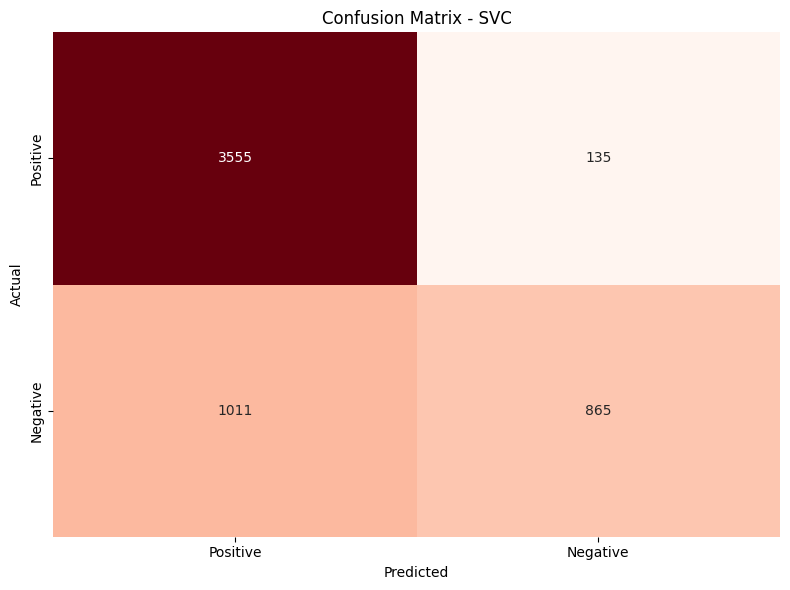

In [78]:
conf_matrix = np.array([[3555, 135],
                        [1011, 865]])

# Plotando a matriz de confusão
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False,
                 xticklabels=['Positive', 'Negative'],
                 yticklabels=['Positive', 'Negative'])

plt.title('Confusion Matrix - SVC')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

### Train and Evaluate Linear SVC

In [62]:
ml = ShallowML(x_train=X_train, x_test=X_test, y_train=y_train, y_test=y_test,
               report_name=None, columns_names= column_selected_names)

best_linear_svm_model = ml.train_best_model(
    model='linear_svc',                               
    score=make_scorer(matthews_corrcoef),
    param_grid=None
)

scores, report, cm, cm2 = ml.score_testset(best_linear_svm_model)
print(report)
print(cm)
for key, value in scores.items():
    print(f"{key}: {value}")

performing gridSearch...
GridSearchCV took 4.19 seconds for 4 candidate parameter settings.
GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scl', None),
                                       ('clf', LinearSVC(random_state=1))]),
             n_jobs=5, param_grid=[{'clf__C': [0.01, 0.1, 1.0, 10]}],
             scoring=make_scorer(matthews_corrcoef, response_method='predict'))
Model with rank: 1
 Mean validation score: 0.548 (std: 0.027)
 Parameters: {'clf__C': 10}
 

Model with rank: 2
 Mean validation score: 0.535 (std: 0.024)
 Parameters: {'clf__C': 1.0}
 

Model with rank: 3
 Mean validation score: 0.496 (std: 0.020)
 Parameters: {'clf__C': 0.1}
 

make_scorer(matthews_corrcoef, response_method='predict')
10
Best score (scorer: make_scorer(matthews_corrcoef, response_method='predict')) and parameters from a 10-fold cross validation:
 MCC score:	0.548
 Parameters:	{'clf__C': 10}

0.478825 (0.024028) with: {'clf__C': 0.01}
0.496133 (0.020401) with: {'clf__C': 0.1}
0.5347

 ### Feature Importance – Linear SVC

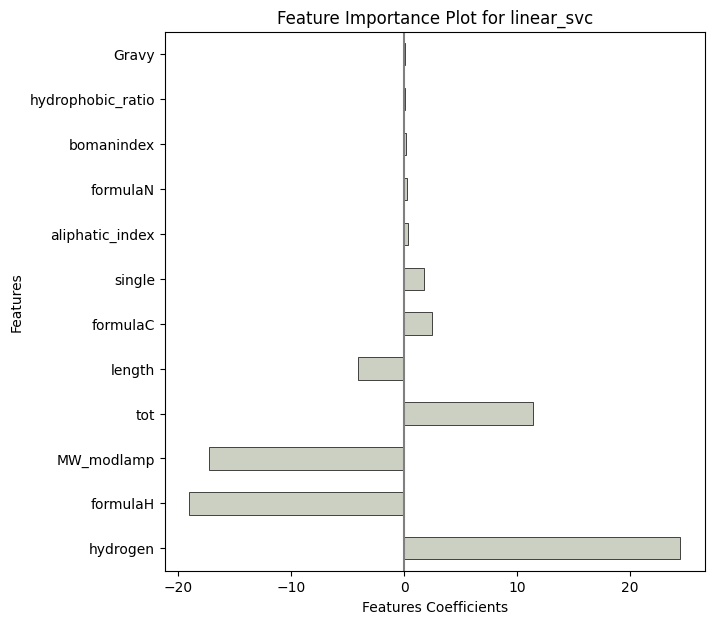

<Figure size 640x480 with 0 Axes>

In [63]:
ml.features_importances_plot(
    classifier=best_linear_svm_model, 
    model_name='linear_svc',
    column_to_plot=0,
    top_features=30, 
    show=True, 
    path_save=None,
    color = '#ccd0c2'
)